### Imports

In [1]:
import librosa  # need pip install librosa
import time
import pickle
import numpy as np
from random import random, shuffle
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size' : 12.5})
from pydub import AudioSegment
import pprint
import os
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif

pp = pprint.PrettyPrinter(indent = 4)

### Loading features + grouping chorus and verse

In [2]:
with open('../chorus_features.p', 'rb') as f:
    c_features = pickle.load(f)
with open('../verse_features.p', 'rb') as f:
    v_features = pickle.load(f)
with open('../feature_names.p', 'rb') as f:
    feature_names = pickle.load(f)  
with open('../song_names.p', 'rb') as f:
    song_names = pickle.load(f)

In [3]:
def group_features(c_features, v_features, subtract=False, song_names=song_names):
    '''
    Combine the chorus and verse features of each song in random order and assign the corresponding label
    If subtract is False: append the two feature vectors in either order
    If subtract is True: the subtraction of one feature vector from the other
    Label: 0 -> Chorus first, verse second
           1 -> Verse first, chorus second
    '''
    assert len(c_features)==len(v_features)==len(song_names)
    
    #create a list with 50% -1 and 50% 1. Shuffle this list. Used for random order, while remaining certain
    #50/50 class balance
    total = len(c_features)
    random_list = [True]*int(np.floor(total/2))+[False]*int(np.ceil(total/2))
    shuffle(random_list)
    song_names = song_names[::-1]
    
    grouped_features = []
    labels = []
    names = []
    
    for i, (chorus, verse) in enumerate(zip(c_features, v_features)):
        
        if random_list[i]: 
            if subtract:
                grouped_features.append(list(chorus-verse)) #c_feats - v_feats
            else:
                grouped_features.append(list(chorus)+list(verse)) #append v_feats to c_feats
            labels.append(0)
            names.append(song_names.pop())
            
        else:
            if subtract:
                grouped_features.append(list(verse-chorus)) #v_feats - c-feats
            else:
                grouped_features.append(list(verse)+list(chorus)) #append c_feats to v_feats
            labels.append(1)
            names.append(song_names.pop())
            
    return grouped_features, labels, names

In [4]:
#Fix feature names vector to include second iteratation over extract_features
all_feature_names = ['1st_'+feature for feature in feature_names]+['2nd_'+feature for feature in feature_names] 

print('Combining chorus and verse features')
subtract = True
features, labels, names = group_features(c_features, v_features, subtract=subtract)
if subtract:
    #Fix feature names vector to include subtraction features
    all_feature_names = feature_names

Combining chorus and verse features


In [5]:
np.shape(features)

(170, 168)

##### Feature Selection

In [6]:
#reduced_features = SelectKBest(f_classif, k=170).fit_transform(features, labels)
feature_selector = SelectPercentile(f_classif, percentile=60)
reduced_features = feature_selector.fit_transform(features, labels)

##### Fix feature names vector with selected features

In [7]:
feature_mask = feature_selector.get_support() #list of booleans for each feature (True: is included)
reduced_feature_names = [] #list of reduced feature names

for used, feature in zip(feature_mask, all_feature_names):
    if used: #If feature is selected, add to new list of feature names
        reduced_feature_names.append(feature)

### Classification and evaluation
#### K-fold Cross Validation:

In [8]:
n_splits = len(reduced_features)//2  # leave-2-out
print('Applying cross validation with {} splits'.format(n_splits))

clf = RandomForestClassifier(n_estimators=300, max_depth=80) #Classifier
predictions = cross_val_predict(clf, reduced_features, labels, cv=n_splits) 

Applying cross validation with 85 splits


In [9]:
# Accuracy
scores = predictions == labels
accuracy = (sum(scores)/len(labels))*100
print('accuracy: {:.2f}% ({})'.format(accuracy, sum(scores)))

assert len(scores) == len(names)
# Misclassification
wrongs = [i for i, x in enumerate(scores) if not x]
wrong_names = sorted([names[i] for i in wrongs])
print('Misclassified: {:.2f}% ({})'.format(100-accuracy, len(wrongs)))
pp.pprint(wrong_names)

accuracy: 75.88% (129)
Misclassified: 24.12% (41)
[   'AllMyLoving',
    'Anna',
    'AnotherOneBitesTheDust',
    'AnotherPartOfMe',
    'AnyTimeAtAll',
    'BabysInBlack',
    'Bad Moon Rising',
    'Ben',
    'BicycleRace',
    'BlackOrWhite',
    'BlameItOnTheBoogie',
    'CryBabyCry',
    'DevilInHerHeart',
    'GotToBeThere',
    'GotToGetYouIntoMyLife',
    'Have You Ever Seen The Rain',
    'Headlong',
    'HelloGoodbye',
    'HereComesTheSun',
    'IWantYouBack',
    'ImHappyJustToDanceWithYou',
    'ImOnlySleeping',
    'ItWontBeLong',
    'Julia',
    'LongLongLong',
    'MagicalMysteryTour',
    'NotASecondTime',
    'NowImHere',
    'PennyLane',
    'RockandRollMusic',
    'RockyRaccoon',
    'ShesLeavingHome',
    'SomebodyToLove',
    'TellMeWhy',
    'TheGirlIsMine',
    'TheWayYouMakeMeFeel',
    'ThinkForYourself',
    'UnderPressure',
    'WayOverYonder',
    'WhenIGetHome',
    'YoureMyBestFriend']


#### One fold train/test split test:

In [10]:
random_state = 666

In [11]:
X_train, X_test, y_train, y_test = train_test_split(reduced_features, labels, \
                                                    test_size=0.1, random_state=random_state)
names_train, names_test,_,_ = train_test_split(names, np.arange(len(names)), \
                                               test_size=0.1, random_state=random_state)

In [12]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
kappa = cohen_kappa_score(y1=y_test, y2=y_pred)

In [13]:
print('Accuracy: {}\nCohen\'s kappa: {}'.format(accuracy, kappa))

Accuracy: 0.7647058823529411
Cohen's kappa: 0.5342465753424657


In [14]:
wrongs = [i for i, x in enumerate(y_pred == y_test) if not x]
wrong_names = [names_test[i] for i in wrongs]
print('Misclassified:', wrong_names)

Misclassified: ['BlackOrWhite', 'MagicalMysteryTour', 'YoureMyBestFriend', 'DoctorRobert']


### Feature importance

In [15]:
#Tuples of feature names and their importance, sorted from low to high
features_with_importance = sorted(list(zip(reduced_feature_names, clf.feature_importances_)),\
                                  key=lambda x:x[1])

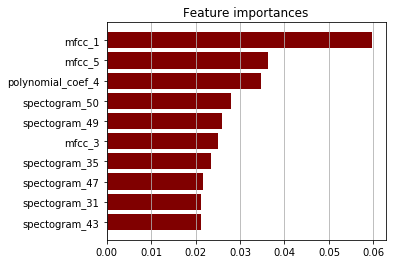

In [16]:
#Number of features to plot
show_n_features = 10
assert show_n_features > 0

#Plot importances
plt.figure(figsize=(5,np.ceil(show_n_features/2.5)))
plt.title("Feature importances")
plt.barh([x[0] for x in features_with_importance[-show_n_features:]],
         [x[1] for x in features_with_importance[-show_n_features:]],
         color="#800000")
plt.grid(axis='x')
plt.show()

In [17]:
# Plotting method for confusion matrices
# From sklearn example code snippets

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Reds):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap);
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='{} confusion matrix'.format('Normalized' if normalize else ''),
           ylabel='True label',
           xlabel='Predicted label');

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor");

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", size=20)
    fig.tight_layout()
    return ax


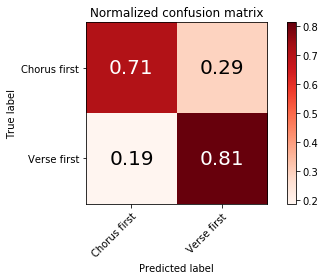

In [18]:
plot_confusion_matrix(labels, predictions, classes=['Chorus first', 'Verse first'], normalize=True);